In [48]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

std_cols: list = ['game', 'model', 'experiment', 'episode']
columns_to_keep: list = ['game', 'model', 'experiment', 'episode', 'Success', 'Lose', 'Aborted']

# save dir for the plots
save_dir: str = "../../plots"

In [44]:
def load_raw_csv(df: pd.DataFrame) -> pd.DataFrame:
    df.metric = df.metric.astype('string')
    df.value = df.value.astype('string')
    df_pivoted = group_raw_csv(df)

    return reduce_to_metrics_for_game(df_pivoted, columns_to_keep)

def group_raw_csv(df: pd.DataFrame) -> pd.DataFrame:
    df_pivoted = df.pivot(index=['game', 'model', 'experiment', 'episode'],
                          columns='metric',
                          values='value')

    # Reset the index to make the index columns regular columns
    df_pivoted = df_pivoted.reset_index()
    return df_pivoted

def reduce_to_metrics_for_game(df: pd.DataFrame, columns_to_keep) -> pd.DataFrame:
    columns_to_keep = std_cols + columns_to_keep
    columns_to_drop = [ c for c in list(df.columns) if c not in columns_to_keep]
    return df.drop(columns=columns_to_drop, axis=1)

In [45]:
base_path_results: str = '/Users/nicolahorst/Documents/GitHub/clem-project_playpen/benchmark_results/clembench/final_models/llama_8B/raw.csv'

# The name of the base model in the raw csv
base_model_name: str = 'Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unsloth-meta-llama-3.1-4bit-plain-t0.0'
# The name of the fine-tuned modelin the raw csv
final_model_name: str = 'llama3.1-8B-sft-e1-DFINAL_0.7K-steps-t0.0--llama3.1-8B-sft-e1-DFINAL_0.7K-steps-t0.0'

# Display name for the plot
model_short_name: str = "Llama-3.1-8B"

df_raw_csv: pd.DataFrame = pd.read_csv(base_path_results, index_col=0)

# transform into clean format
clean_csv_data = load_raw_csv(df_raw_csv)

for col in clean_csv_data.columns:
    if col not in std_cols:
        clean_csv_data[col] = pd.to_numeric(clean_csv_data[col], errors='coerce')

clean_csv_data.fillna(0)
# fill success lost abort with 0

metric,game,model,experiment,episode,Aborted,Lose,Success
0,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_home_deliver_three_basic_easy,episode_0,0.0,0.0,1.0
1,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_home_deliver_three_basic_easy,episode_1,0.0,0.0,1.0
2,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_home_deliver_three_basic_easy,episode_10,0.0,1.0,0.0
3,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_home_deliver_three_basic_easy,episode_11,0.0,1.0,0.0
4,adventuregame,Unsloth-meta-llama-3.1-4bit-plain-t0.0--Unslot...,0_home_deliver_three_basic_easy,episode_12,1.0,0.0,0.0
...,...,...,...,...,...,...,...
4840,wordle_withcritic,llama3.1-sft-e1-_E1_D40005-t0.0--llama3.1-sft-...,1_medium_frequency_words_clue_with_critic,episode_5,1.0,0.0,0.0
4841,wordle_withcritic,llama3.1-sft-e1-_E1_D40005-t0.0--llama3.1-sft-...,1_medium_frequency_words_clue_with_critic,episode_6,1.0,0.0,0.0
4842,wordle_withcritic,llama3.1-sft-e1-_E1_D40005-t0.0--llama3.1-sft-...,1_medium_frequency_words_clue_with_critic,episode_7,1.0,0.0,0.0
4843,wordle_withcritic,llama3.1-sft-e1-_E1_D40005-t0.0--llama3.1-sft-...,1_medium_frequency_words_clue_with_critic,episode_8,1.0,0.0,0.0


# utils to prepare the labels

In [32]:
def mapLostToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Lose'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToAborted(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Aborted'] == 1:
        return 1

    return 0

def mapSuccessToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Success'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def mapLostToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Lose'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToSuccess(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Success'] == 1:
        return 1

    return 0

def mapAbortedToLost(row, baseline_df):
    game = row['game']
    experiment = row['experiment']
    episode = row['episode']

    basline_loss = baseline_df[(baseline_df['game'] == game) &
                               (baseline_df['experiment'] == experiment) &
                               (baseline_df['episode'] == episode)]['Aborted'].iloc[0]  # Get the scalar value

    if basline_loss == 1 and row['Lose'] == 1:
        return 1

    return 0

def map_model_name_to_simple_rep(model_name):
    model_name_lookup = {
    base_model_name: "L3-8B (Baseline)",
    final_model_name: "L3-8B (Tuned)",
    }

    return model_name_lookup[model_name]

games = clean_csv_data.game.unique()

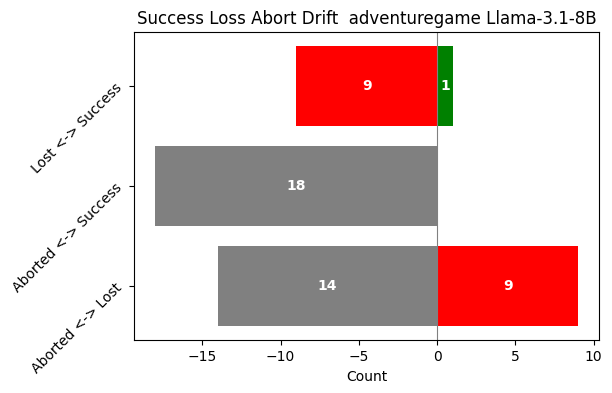

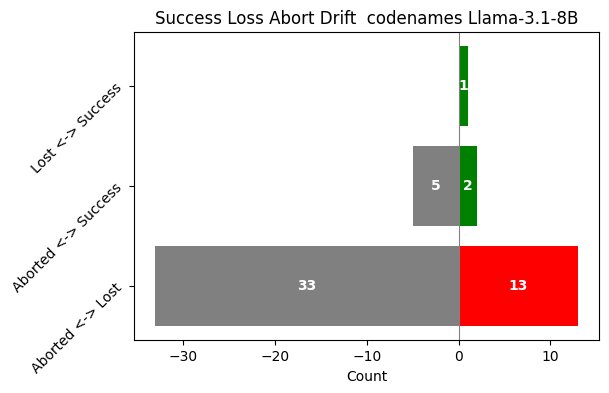

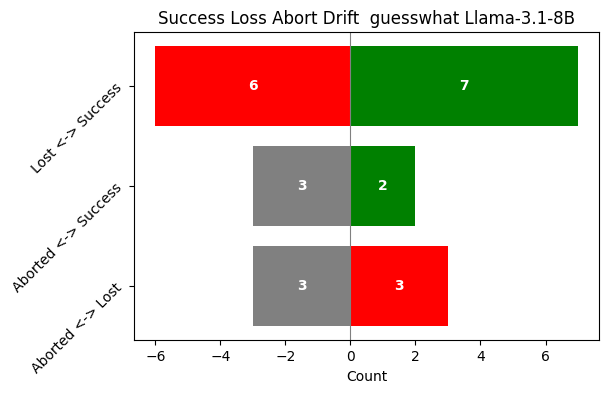

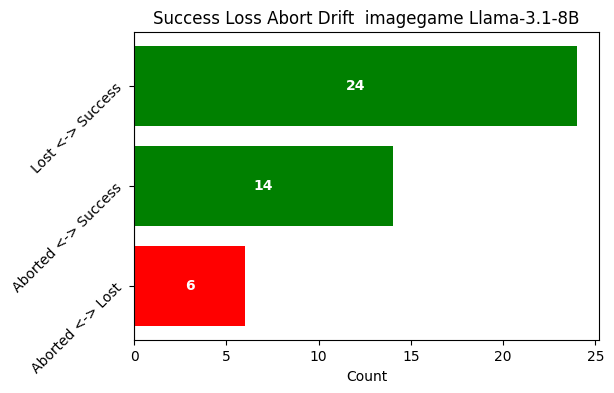

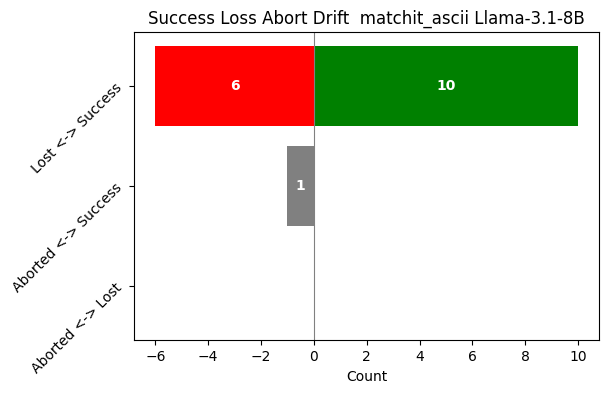

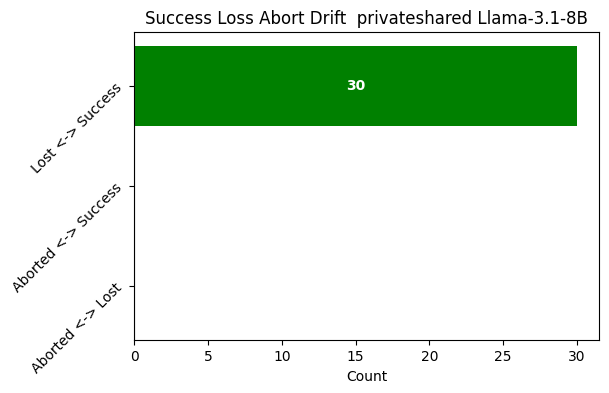

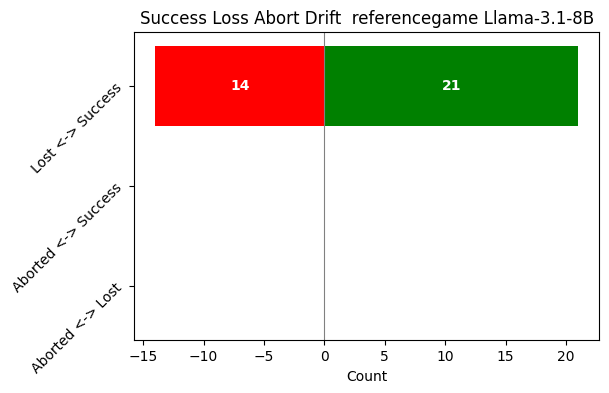

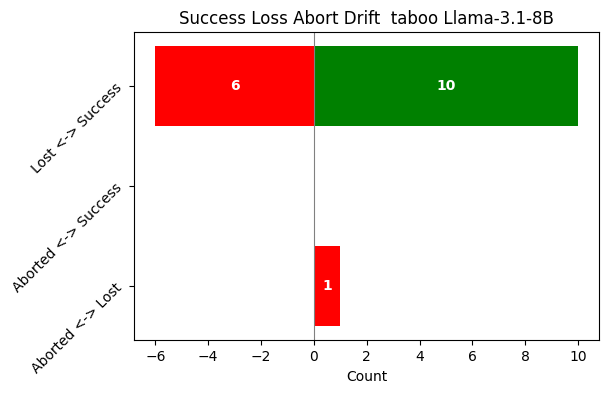

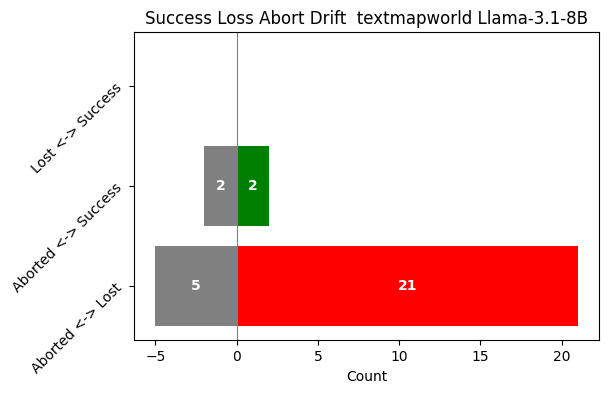

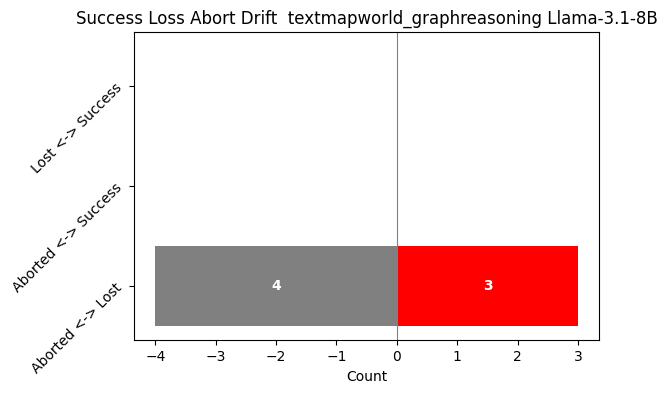

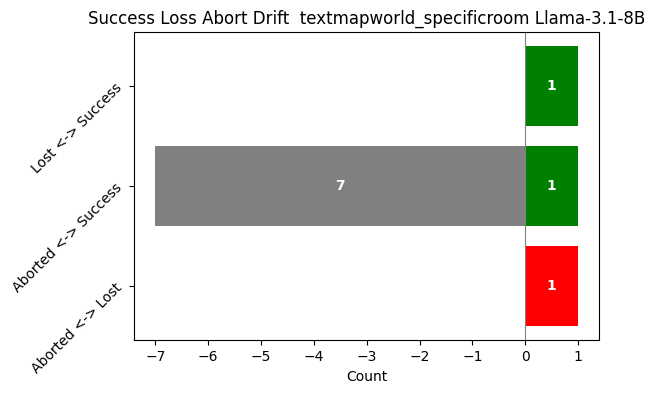

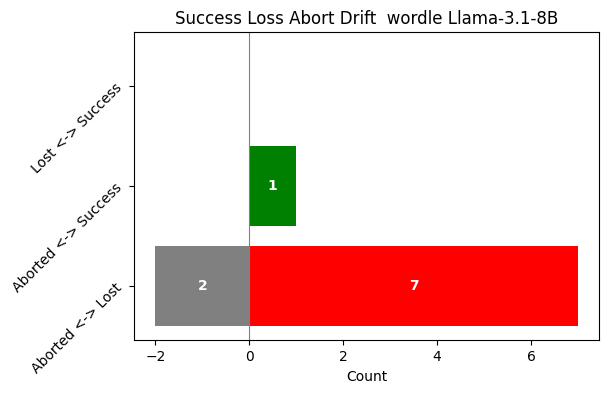

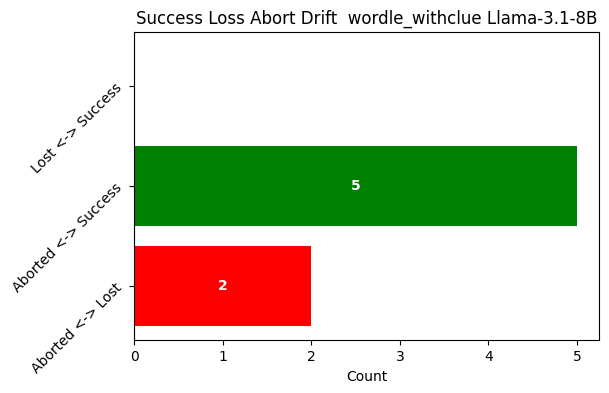

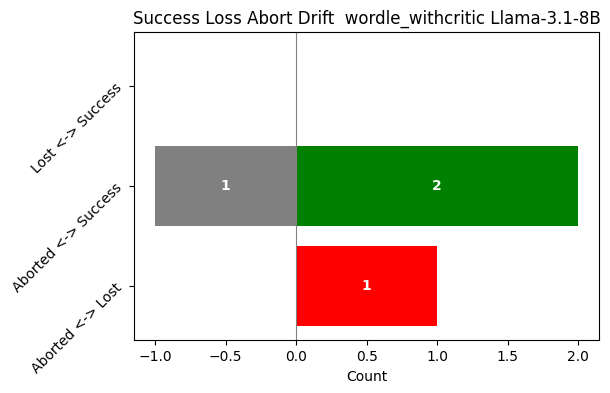

In [38]:
import matplotlib.pyplot as plt
import numpy as np

for game in games:
    # Create a figure with 3 horizontal subplots
    fig, ax = plt.subplots(figsize=(6, 4), sharey=True)

    df_baseline = clean_csv_data[(clean_csv_data.model == base_model_name) & (clean_csv_data.game == game)].fillna(0)
    cleaned_data = clean_csv_data[(clean_csv_data.model == final_model_name) & (clean_csv_data.game == game)].fillna(0)

    # Apply mapping functions
    cleaned_data['lost_to_aborted'] = cleaned_data.apply(lambda x: mapLostToAborted(x, df_baseline), axis=1)
    cleaned_data['success_to_aborted'] = cleaned_data.apply(lambda x: mapSuccessToAborted(x, df_baseline), axis=1)
    cleaned_data['success_to_lost'] = cleaned_data.apply(lambda x: mapSuccessToLost(x, df_baseline), axis=1)
    cleaned_data['lost_to_success'] = cleaned_data.apply(lambda x: mapLostToSuccess(x, df_baseline), axis=1)
    cleaned_data['aborted_to_success'] = cleaned_data.apply(lambda x: mapAbortedToSuccess(x, df_baseline), axis=1)
    cleaned_data['aborted_to_lost'] = cleaned_data.apply(lambda x: mapAbortedToLost(x, df_baseline), axis=1)

    # Change model name for display
    cleaned_data.model = cleaned_data.model.apply(lambda x: map_model_name_to_simple_rep(x))

    # Filter for each transition
    lost_to_aborted = cleaned_data[(cleaned_data.lost_to_aborted == 1)]
    success_to_aborted = cleaned_data[(cleaned_data.success_to_aborted == 1)]
    success_to_loss = cleaned_data[(cleaned_data.success_to_lost == 1)]
    lost_to_success = cleaned_data[(cleaned_data.lost_to_success == 1)]
    aborted_to_success = cleaned_data[(cleaned_data.aborted_to_success == 1)]
    aborted_to_lost = cleaned_data[(cleaned_data.aborted_to_lost == 1)]

    # Data for bars
    categories = ['Aborted <-> Lost', 'Aborted <-> Success', 'Lost <-> Success']

    positive_values = [len(aborted_to_lost), len(aborted_to_success), len(lost_to_success)]
    negative_values = [-len(lost_to_aborted), -len(success_to_aborted), -len(success_to_loss)]

    y_pos = np.arange(len(categories))
    pos_bars = ax.barh(y_pos, positive_values, color=['r', 'g', 'g'], label='Positive Development')
    neg_bars = ax.barh(y_pos, negative_values, color=['grey', 'grey', 'r'], label='Negative Development')

    # Add value labels inside the bars
    def add_value_labels(bars):
        for bar in bars:
            width = bar.get_width()
            x_pos = width/2 if width >= 0 else width/2
            value = abs(width)
            if value == 0:
                pass
            else:
                ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                        f'{int(value)}',
                        ha='center', va='center',
                        color='white', fontweight='bold')

    # add values into labels
    add_value_labels(pos_bars)
    add_value_labels(neg_bars)

    # Customize subplot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories, rotation=45, ha='right')

    ax.set_xlabel('Count')
    ax.set_title(f"Success Loss Abort Drift  {game} {model_short_name}" )

    # set middle line
    ax.axvline(0, color='grey', linewidth=0.8)

    plt.savefig(f'{save_dir}/success_lost_abort_drift_{game}_{model_short_name}.png')
    plt.show()


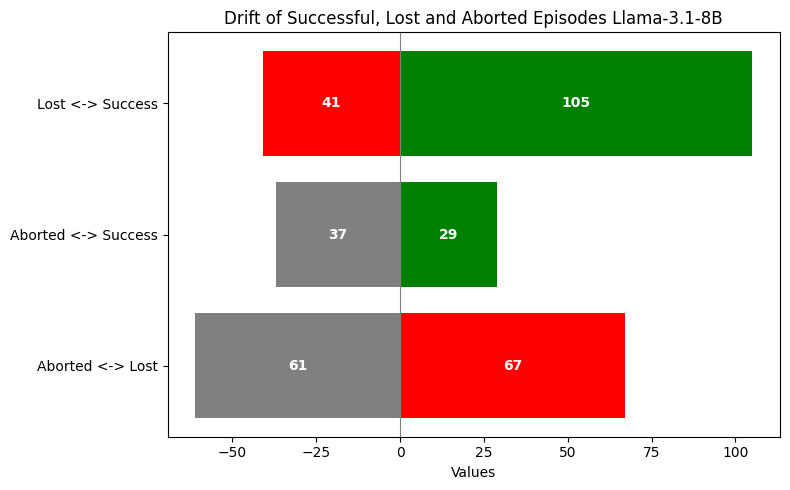

In [51]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

df_baseline = clean_csv_data[clean_csv_data.model == base_model_name].fillna(0)
cleaned_data = clean_csv_data[clean_csv_data.model == final_model_name].fillna(0)

# Apply mapping functions
cleaned_data['lost_to_aborted'] = cleaned_data.apply(lambda x: mapLostToAborted(x, df_baseline), axis=1)
cleaned_data['success_to_aborted'] = cleaned_data.apply(lambda x: mapSuccessToAborted(x, df_baseline), axis=1)
cleaned_data['success_to_lost'] = cleaned_data.apply(lambda x: mapSuccessToLost(x, df_baseline), axis=1)
cleaned_data['lost_to_success'] = cleaned_data.apply(lambda x: mapLostToSuccess(x, df_baseline), axis=1)
cleaned_data['aborted_to_success'] = cleaned_data.apply(lambda x: mapAbortedToSuccess(x, df_baseline), axis=1)
cleaned_data['aborted_to_lost'] = cleaned_data.apply(lambda x: mapAbortedToLost(x, df_baseline), axis=1)

# Filter for each transition
lost_to_aborted = cleaned_data[(cleaned_data.lost_to_aborted == 1)]
success_to_aborted = cleaned_data[(cleaned_data.success_to_aborted == 1)]
success_to_loss = cleaned_data[(cleaned_data.success_to_lost == 1)]
lost_to_success = cleaned_data[(cleaned_data.lost_to_success == 1)]
aborted_to_success = cleaned_data[(cleaned_data.aborted_to_success == 1)]
aborted_to_lost = cleaned_data[(cleaned_data.aborted_to_lost == 1)]

# Data for bars
categories = ['Aborted <-> Lost', 'Aborted <-> Success', 'Lost <-> Success']

positive_values = [len(aborted_to_lost), len(aborted_to_success), len(lost_to_success)]
negative_values = [-len(lost_to_aborted), -len(success_to_aborted), -len(success_to_loss)]
# Create horizontal bars
y_pos = np.arange(len(categories))
pos_bars = ax.barh(y_pos, positive_values, color=['r', 'g', 'g'], label='Positive Development')
neg_bars = ax.barh(y_pos, negative_values, color=['grey', 'grey', 'r'], label='Negative Development')

# Add value labels inside the bars
def add_value_labels(bars):
    for bar in bars:
        width = bar.get_width()
        x_pos = width/2 if width >= 0 else width/2
        # Get absolute value for display
        value = abs(width)
        ax.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{int(value)}',
                ha='center', va='center',
                color='white', fontweight='bold')

add_value_labels(pos_bars)
add_value_labels(neg_bars)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(categories)
ax.set_xlabel('Values')
ax.set_title(f'Drift of Successful, Lost and Aborted Episodes {model_short_name}' )

# Add a vertical line at x=0
ax.axvline(0, color='grey', linewidth=0.8)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(f'{save_dir}/success_lost_abort_drift_{model_short_name}.png')
plt.show()
